In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Configuración general
folder_path = r"C:\Users\Ibon\PycharmProjects\Microgrid\TrainTestSplit"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Función para cargar y preprocesar datos
def load_and_preprocess(files):
    df_list = []
    for file in files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, parse_dates=["Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss"])
        df = df.drop(columns='Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss')
        
        # Muestreo estratificado por source
        df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))
        df_list.append(df_sampled)
    
    full_df = pd.concat(df_list, ignore_index=True)
    
    # One-hot encoding para source
    full_df = pd.get_dummies(full_df, columns=['source'], prefix='src')
    
    return full_df

# Cargar datos de entrenamiento y prueba
train_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f]
test_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and "test" in f]

train_df = load_and_preprocess(train_files)
test_df = load_and_preprocess(test_files)

# Alinear columnas entre train y test
train_cols = train_df.columns
test_df = test_df.reindex(columns=train_cols).fillna(0)

# Separar características y target
X_train = train_df.drop(columns=['Pmp (W)']).values.astype(np.float32)
X_test = test_df.drop(columns=['Pmp (W)']).values.astype(np.float32)
y_train = train_df['Pmp (W)'].values.astype(np.float32)
y_test = test_df['Pmp (W)'].values.astype(np.float32)

# Escalado de características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convertir a tensores
X_train_tensor = torch.tensor(X_train).to(device)
y_train_tensor = torch.tensor(y_train).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test).to(device)
y_test_tensor = torch.tensor(y_test).unsqueeze(1).to(device)

In [3]:
# Modelo mejorado
class EnhancedDNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.model(x)

In [4]:
# Inicializar modelo
input_dim = X_train.shape[1]
model = EnhancedDNN(input_dim).to(device)

# Configurar entrenamiento
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
criterion = nn.MSELoss()

# Entrenamiento con early stopping
epochs = 200
best_loss = np.inf
patience = 12
counter = 0
train_losses = []

C:\Users\Ibon\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    
    avg_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    scheduler.step(avg_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    
    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        torch.save(model.state_dict(), "best_model_all_data.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

# Cargar mejor modelo
model.load_state_dict(torch.load("best_model_all_data.pth"))

Epoch [1/200], Loss: 678.1325
Epoch [2/200], Loss: 67.5014
Epoch [3/200], Loss: 52.8554
Epoch [4/200], Loss: 46.2611
Epoch [5/200], Loss: 41.2669
Epoch [6/200], Loss: 38.0980
Epoch [7/200], Loss: 36.1599
Epoch [8/200], Loss: 33.9507
Epoch [9/200], Loss: 31.6595
Epoch [10/200], Loss: 31.1581
Epoch [11/200], Loss: 29.4677
Epoch [12/200], Loss: 28.4450
Epoch [13/200], Loss: 28.0352
Epoch [14/200], Loss: 27.5539
Epoch [15/200], Loss: 26.1875
Epoch [16/200], Loss: 26.1563
Epoch [17/200], Loss: 25.7667
Epoch [18/200], Loss: 25.3345
Epoch [19/200], Loss: 25.4642
Epoch [20/200], Loss: 24.2846
Epoch [21/200], Loss: 23.8776
Epoch [22/200], Loss: 23.8426
Epoch [23/200], Loss: 22.9669
Epoch [24/200], Loss: 22.5459
Epoch [25/200], Loss: 22.4843
Epoch [26/200], Loss: 21.6431
Epoch [27/200], Loss: 21.7424
Epoch [28/200], Loss: 21.9232
Epoch [29/200], Loss: 21.3166
Epoch [30/200], Loss: 21.2517
Epoch [31/200], Loss: 20.8981
Epoch [32/200], Loss: 20.2147
Epoch [33/200], Loss: 20.3585
Epoch [34/200], Lo

C:\Users\Ibon\AppData\Local\Temp\ipykernel_16076\723648750.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_all_data.pth"))


<All keys matched successfully>


📊 Test MSE: 16.5034
📏 Test MAE: 3.0013
📈 Test R2: 0.9886
MAE para Cocoa_CIGS39017.csv: 3.23
MAE para Cocoa_CIGS8-001.csv: 3.23
MAE para Cocoa_CdTe75638.csv: 3.21
MAE para Cocoa_HIT05667.csv: 6.04
MAE para Cocoa_aSiMicro03036.csv: 2.43
MAE para Cocoa_aSiTandem72-46.csv: 2.31
MAE para Cocoa_aSiTriple28324.csv: 3.17
MAE para Cocoa_mSi0166.csv: 2.40
MAE para Cocoa_mSi0188.csv: 2.34
MAE para Cocoa_mSi460A8.csv: 3.64
MAE para Cocoa_xSi12922.csv: 3.80
MAE para Eugene_CIGS39017.csv: 2.57
MAE para Eugene_CIGS8-001.csv: 2.42
MAE para Eugene_CdTe75638.csv: 2.51
MAE para Eugene_HIT05667.csv: 4.87
MAE para Eugene_aSiMicro03036.csv: 1.94
MAE para Eugene_aSiTandem72-46.csv: 1.72
MAE para Eugene_aSiTriple28324.csv: 2.54
MAE para Eugene_mSi0166.csv: 1.97
MAE para Eugene_mSi0188.csv: 1.93
MAE para Eugene_mSi460A8.csv: 3.01
MAE para Eugene_xSi12922.csv: 3.15
MAE para Golden_CIGS1-001.csv: 3.92
MAE para Golden_CIGS39013.csv: 3.37
MAE para Golden_CdTe75669.csv: 3.50
MAE para Golden_HIT05662.csv: 7.14
MAE 

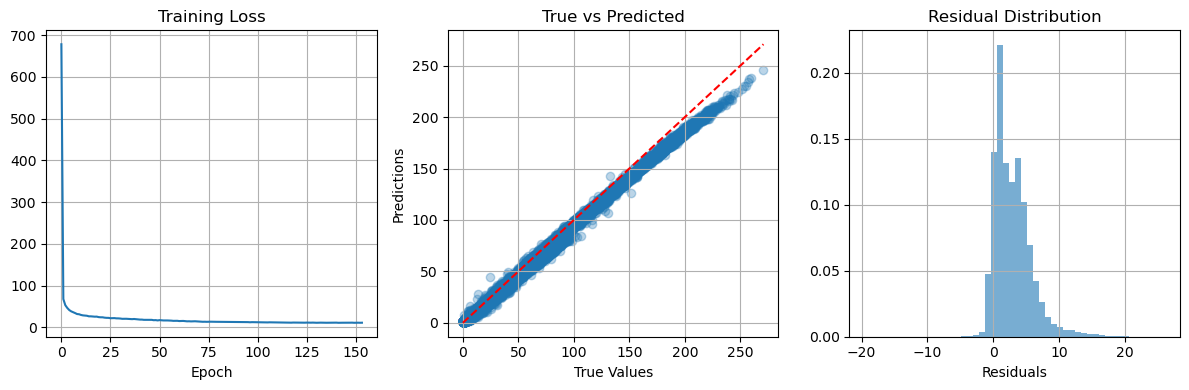

In [8]:
# Evaluación
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    # Métricas generales
    mse = mean_squared_error(y_test_np, y_pred)
    mae = mean_absolute_error(y_test_np, y_pred)
    r2 = r2_score(y_test_np, y_pred)
    
    print(f"\n📊 Test MSE: {mse:.4f}")
    print(f"📏 Test MAE: {mae:.4f}")
    print(f"📈 Test R2: {r2:.4f}")
    
    # Métricas por source
    test_df['pred'] = y_pred
    for col in test_df.filter(regex='^src_').columns:
        if test_df[col].sum() > 0:  # Solo para sources presentes en test
            source_name = col.replace('src_', '')
            subset = test_df[test_df[col] == 1]
            if not subset.empty:
                source_mae = mean_absolute_error(subset['Pmp (W)'], subset['pred'])
                print(f"MAE para {source_name}: {source_mae:.2f}")

# Gráficos
plt.figure(figsize=(12, 4))

# Pérdida de entrenamiento
plt.subplot(131)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.grid(True)

# Predicciones vs Reales
plt.subplot(132)
plt.scatter(y_test_np, y_pred, alpha=0.3)
plt.plot([0, y_test_np.max()], [0, y_test_np.max()], 'r--')
plt.title('True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)

# Residuos
plt.subplot(133)
residuals = y_test_np - y_pred
plt.hist(residuals, bins=50, density=True, alpha=0.6)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.grid(True)

plt.tight_layout()
plt.show()